# Exogenous degrees of freedom

As we mentioned in previous pages, some degrees of freedom can be
designated as *exogenous*, meaning that their behavior is determined
by some external process that we do not model explicitly. In practice,
that means that the acceleration of such a degree of freedom must
by explicitly provided at every time step while the state vector is being
advanced.

In [1]:
using RigidBodyTools
using Plots

As usual, we will demonstrate this via an example. In the example,
a single flat plate will be commanded to pitch upward by 45 degrees
about its leading edge. It will move steadily in the +x direction.
However, its y acceleration will vary randomly via some exogenous process.

In [2]:
Xp_to_jp = MotionTransform(0.0,0.0,0.0)
Xc_to_jc = MotionTransform(0.5,0.0,0.0)
dofs = [SmoothRampDOF(0.4,π/4,0.5),ConstantVelocityDOF(1.0),ExogenousDOF()]
joint = Joint(FreeJoint2d,0,Xp_to_jp,1,Xc_to_jc,dofs)

body = ThickPlate(1.0,0.05,0.02)

Thick plate with 104 points and length 1.0 and thickness 0.05
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


We need to provide a means of passing along the time-varying information about
the exogenous acclerations to the time integrator. There are two ways we
can do this.
#### Method 1: A function for exogenous acclerations.
We can provide a function that will specify the exogenous y acceleration.
Here, we will create a function that sets it to a random value chosen from a
normal distribution. Note that the function must be mutating and have a signature
`(a,x,p,t)`, where `a` is the exogenous acceleration vector. The arguments `x`
and `p` are a state and a parameter, which can be flexibly defined.
Here, the *state* is the rigid-body system state and the *parameter*
is the `RigidBodyMotion` structure.
The last argument `t` is time.

In this example, we don't need any of those arguments.

In [3]:
function my_exogenous_function!(a,x,ls,t)
    a .= randn(length(a))
end

my_exogenous_function! (generic function with 1 method)

We pass that along via the `exogenous` keyword argument.

In [4]:
ls = RigidBodyMotion(joint,body;exogenous=my_exogenous_function!)

1 linked system(s) of bodies
   1 bodies
   1 joints


#### Method 2: Setting the exogenous accelerations explicitly in the loop
Another approach we can take is to set the exogenous acceleration(s)
explicitly in the loop, using the `update_exogenous!` function.
This function saves the vector of accelerations in a buffer in the `RigidBodyMotion`
structure so that it is available to the time integrator. We will
demonstrate that approach here.

In [5]:
ls = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Let's initialize the state vector and its rate of change

In [6]:
bc = deepcopy(body)
dt, tmax = 0.01, 3.0
t0, x0 = 0.0, init_motion_state(bc,ls)
dxdt = zero(x0)
x = copy(x0)

4-element Vector{Float64}:
 3.036647512353532e-7
 0.0
 0.0
 0.0

Note that the state vector has four elements. The first two are
associated with the prescribed motions for rotation and x translation.
The third is the y position, the exogenous degree of freedom. And the
fourth is the y velocity.

Why the y velocity? Because the exogenous behavior is specified via its
acceleration. Let's advance the system and animate it. We include
a horizontal line along the hinge axis to show the effect of the exogenous
motion.

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_aroPIrOzaB.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_aroPIrOzaB.gif")
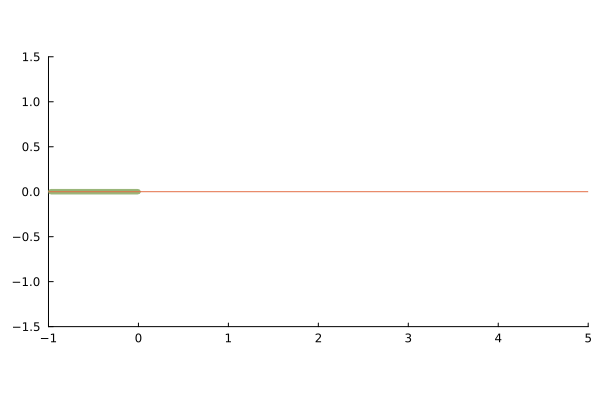

In [7]:
xhist = []
a_edof = zero_exogenous(ls)
@gif for t in t0:dt:t0+tmax

  a_edof .= randn(length(a_edof))

  update_exogenous!(ls,a_edof)
  motion_rhs!(dxdt,x,(ls,bc),t)
  global x += dxdt*dt
  update_body!(bc,x,ls)

  push!(xhist,copy(x))
  plot(bc,xlims=(-1,5),ylims=(-1.5,1.5))
  hline!([0.0])
end every 5

Let's plot the exogenous state and its velocity

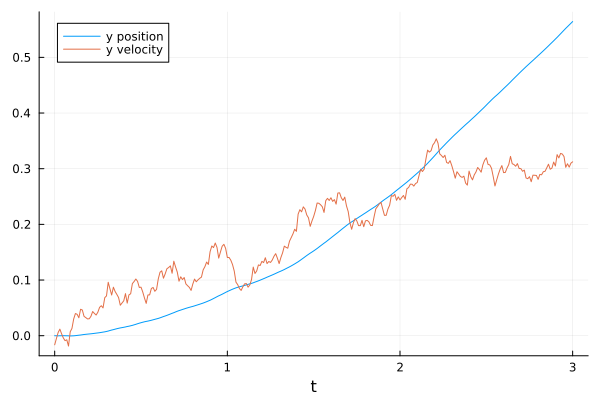

In [8]:
plot(t0:dt:t0+tmax,map(x -> exogenous_position_vector(x,ls,1)[1],xhist),label="y position",xlabel="t")
plot!(t0:dt:t0+tmax,map(x -> exogenous_velocity_vector(x,ls,1)[1],xhist),label="y velocity")

The variation in velocity is quite noisy (and constitutes a random walk).
In contrast, the change in position is relatively smooth, since it represents
an integral of this velocity.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*